# Imports

In [15]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
import joblib

# diferentes tipos de experimentos
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

import matplotlib.pyplot as plt

import time
import dependencies as dep

In [2]:
SIZE = 400

PATH = '../data/data.csv'
PATH_BALANCED = f'../data/data_balanced_{SIZE}.csv'
MODEL_PATH = '../knn.pkl'

X = 1
O = -1
BLANK = 0

O_WIN   = 0
DRAW    = 1
ONGOING = 2
X_WIN   = 3

# Preparo dos Dados
Devido o péssimo desempenho deste algoritmo até então, vou seguir algumas práticas para dados desbalanceados.

Referências seguidas:

- [Imbalanced Datasets - Google Developers](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets?hl=pt-br)
- [Best Cross-Validation for Imbalanced Data](https://www.reddit.com/r/datascience/comments/1hba8s2/best_crossvalidation_for_imbalanced_data/)
- [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [kNN and unbalanced classes](https://stats.stackexchange.com/questions/341/knn-and-unbalanced-classes)

In [3]:
df = pd.read_csv(PATH_BALANCED)
feature_cols = [str(i) for i in range(9)]
X = df[feature_cols]

y = df['category']
df.sample(10)

,0,1,2,3,4,5,6,7,8,category
2163,-1,1,-1,-1,1,-1,1,-1,1,1
43,-1,1,1,-1,0,1,-1,1,-1,0
1446,0,1,0,-1,1,-1,-1,1,1,3
1666,0,-1,1,0,-1,-1,1,1,1,3
1749,-1,1,-1,0,-1,0,1,1,1,3
2155,-1,1,-1,-1,-1,1,1,-1,1,1
1537,-1,0,-1,-1,0,1,1,1,1,3
153,-1,1,0,-1,1,0,-1,0,1,0
2028,1,1,-1,-1,1,1,1,-1,-1,1
750,0,0,0,0,0,1,0,-1,0,2


In [5]:
X_train, X_temp, y_train, y_temp = tts(X, y, test_size=0.4, random_state=12, stratify=y)
X_val, X_test, y_val, y_test = tts(X_temp, y_temp, test_size=0.5, random_state=12, stratify=y_temp)

# Treinamento

In [11]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=11, random_state=42)

param_grid = {
    'n_neighbors' : [1, 2, 3, 4, 5, 6, 7],
    'weights' : ['distance', 'uniform'],
    'p' : [1, 2]
}
knn = KNeighborsClassifier(metric='minkowski')
grid = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', return_train_score=True, n_jobs=-1)

train_start = time.time()
model = grid.fit(X_train.to_numpy(), y_train.to_numpy())
train_end = time.time()
print(f"Tempo de Indução: {train_end-train_start} segundos")

Tempo de Indução: 45.50603747367859 segundos


Melhores Hiperparâmetros={'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
Melhor F1=0.8610318451073515


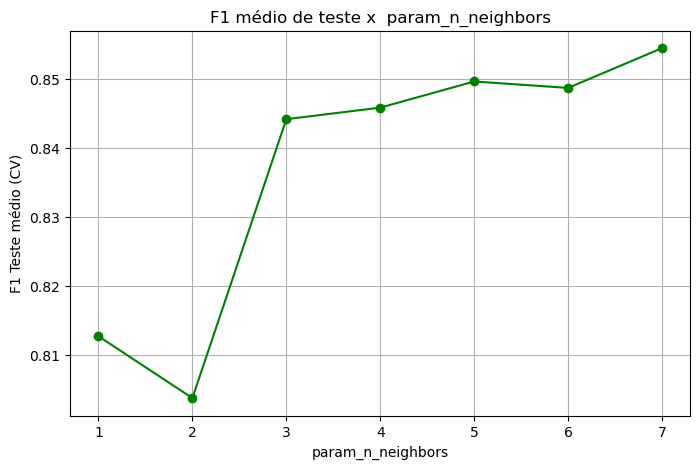

    param_n_neighbors param_weights  param_p  mean_test_score
26                  7      distance        2         0.861032
22                  6      distance        2         0.858458
27                  7       uniform        2         0.858017
18                  5      distance        2         0.856574
14                  4      distance        2         0.856445
24                  7      distance        1         0.853521
19                  5       uniform        2         0.852638
10                  3      distance        2         0.851683
20                  6      distance        1         0.850285
23                  6       uniform        2         0.849028
16                  5      distance        1         0.848805
15                  4       uniform        2         0.847039
11                  3       uniform        2         0.846722
25                  7       uniform        1         0.845174
12                  4      distance        1         0.845114


In [16]:
print('Melhores Hiperparâmetros='+str(model.best_params_))
print('Melhor F1=' + str(model.best_score_))
results = pd.DataFrame(model.cv_results_)

# Agrupa por max_depth e calcula média do mean_test_score
agg_dt = (results
        .groupby('param_n_neighbors')['mean_test_score']
        .mean()
        .reset_index())

plt.figure(figsize=(8, 5))
plt.plot(agg_dt['param_n_neighbors'], agg_dt['mean_test_score'], marker='o', color='green')
plt.xlabel('param_n_neighbors')
plt.ylabel('F1 Teste médio (CV)')
plt.title('F1 médio de teste x  param_n_neighbors')
plt.grid(True)
plt.show()

print(results[['param_n_neighbors', 'param_weights', 'param_p', 'mean_test_score']]
    .sort_values(by='mean_test_score', ascending=False)
  .head(15))

========== MÉTRICAS ==========
Tempo de Execução de Testes = 0.0090 segundos
              precision    recall  f1-score   support

           0     0.8571    0.9500    0.9012       120
           1     0.9023    1.0000    0.9486       120
           2     0.9157    0.6333    0.7488       120
           3     0.9008    0.9833    0.9402       120

    accuracy                         0.8917       480
   macro avg     0.8940    0.8917    0.8847       480
weighted avg     0.8940    0.8917    0.8847       480

========== ANÁLISE DE RESULTADOS ==========


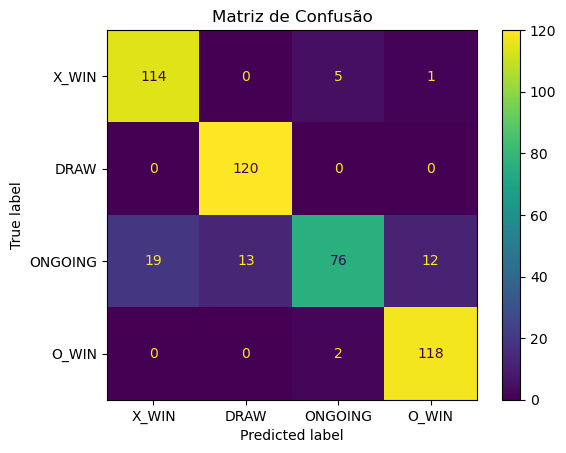

In [13]:
dep.test(model, X_val, y_val)

In [14]:
joblib.dump(knn, MODEL_PATH)
print(f'KNN salvo em {MODEL_PATH}')

KNN salvo em ../knn.pkl
